In [12]:
%pylab inline

import katarchive
import datetime
import katpoint
import calendar

import logging

# needed to supress search outputs
from contextlib import contextmanager
import sys, os

katarchive.product_filter.only_ar1()
 
@contextmanager
def suppress_stdout():
    with open(os.devnull, "w") as devnull:
        old_stdout = sys.stdout
        sys.stdout = devnull
        try:  
            yield
        finally:
            sys.stdout = old_stdout

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [13]:
year="2016"
month="10"

In [14]:
def findh5(det):   # uses detail list to get h5 name
    pos=det.find("staging/")
    if pos >0  :
        pr2=det[pos+8:pos+18]
        h5name=pr2
    return h5name

In [15]:
f = katarchive.search_archive(startdate='01/10/2016',enddate='31/10/2016')
start = datetime.datetime.strptime(f[-1].metadata.StartTime,'%Y-%m-%d %H:%M:%S %Z')
end = datetime.datetime.strptime(f[0].metadata.StartTime,'%Y-%m-%d %H:%M:%S %Z')

Searched using: CAS.ProductTypeName:(MeerKATAR1TelescopeProduct) AND CAS.ProductTransferStatus:RECEIVED AND StartTime:[2016-09-30T22:00:00Z TO 2016-10-31T21:59:59Z]
Returning 208 results


In [16]:
f.sort(key=lambda k: k.metadata.StartTime)

In [17]:
print f[0].metadata.StartTime
print f[-1].metadata.StartTime
print datetime.datetime.strptime(f[0].metadata.StartTime,'%Y-%m-%d %H:%M:%S %Z')
print datetime.datetime.strptime(f[-1].metadata.StartTime,'%Y-%m-%d %H:%M:%S %Z')
print start.toordinal()
print end.toordinal()

2016-10-02 23:21:53 SAST
2016-10-25 05:50:17 SAST
2016-10-02 23:21:53
2016-10-25 05:50:17
736239
736262


In [18]:
program_id = []
duration = []
antennas = []
for fi in f:
    # now try extract the project-id from the instruction-set string
    script = fi.metadata.InstructionSet.encode('ascii','ignore') 
    spl = script.split()
    for i,s in enumerate(spl):
        if '--project-id' in s or '--proposal-id' in s:
            if '=' in s: #some people use --project-id=yyyymmddNN-01 and some --project-id yyyymmddNN-01
                if s[-1] == '=':
                    p = spl[i+1]
                    break
                p = s.split('=')[-1]
                break
            else:
                if spl[i+1][0] == '=' and len(spl[i+1]) > 1:
                    p = spl[i+1][1:]
                    break
                elif spl[i+1][0] == '=' and len(spl[i+1]) == 1:
                    p = spl[i+2]
                    break
                p = spl[i+1]
            break
        else:
            p = 'No-project-id' 
    program_id.append(p)
    duration.append(fi.metadata.Duration)
    antennas.append(len(fi.metadata.Antennas))
program_id = array(program_id)
duration = array(duration)
antennas = array(antennas)
p_cent = (sum(duration)/((end.toordinal()-start.toordinal())*24*3600))*100

print 'Percentage system usage: %4.2f%%'%p_cent

Percentage system usage: 29.44%


In [19]:
print sum(duration)

584934.59


In [20]:
for i in range(1,16):
    ind = antennas == i
    p_cent = (sum(duration[ind])/((end.toordinal()-start.toordinal())*24*3600))*100
    print 'Percentage system usage with %i antennas: %4.2f%%'%(i, p_cent)

Percentage system usage with 1 antennas: 0.12%
Percentage system usage with 2 antennas: 0.22%
Percentage system usage with 3 antennas: 0.00%
Percentage system usage with 4 antennas: 0.03%
Percentage system usage with 5 antennas: 0.16%
Percentage system usage with 6 antennas: 0.45%
Percentage system usage with 7 antennas: 0.59%
Percentage system usage with 8 antennas: 0.27%
Percentage system usage with 9 antennas: 11.16%
Percentage system usage with 10 antennas: 8.11%
Percentage system usage with 11 antennas: 8.16%
Percentage system usage with 12 antennas: 0.17%
Percentage system usage with 13 antennas: 0.00%
Percentage system usage with 14 antennas: 0.00%
Percentage system usage with 15 antennas: 0.00%


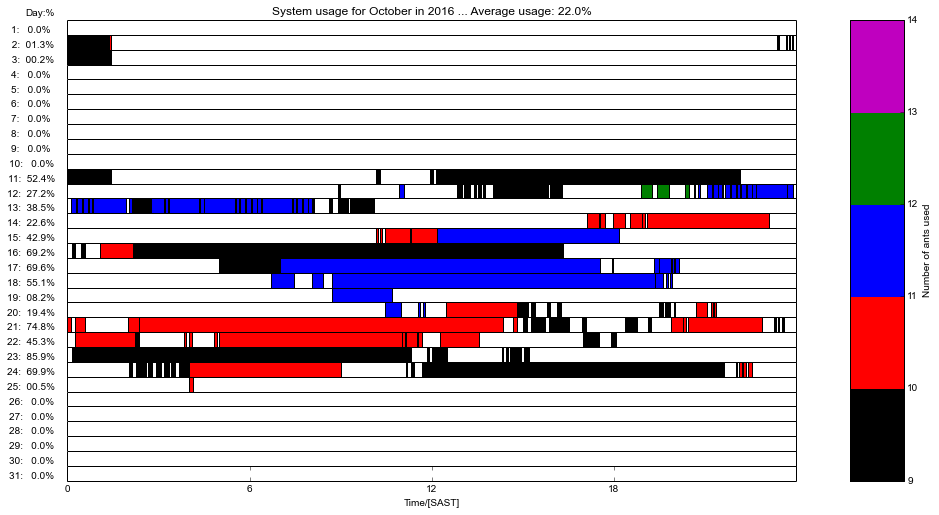

In [21]:
month = int(month)
#day = int(day)
year = int(year)
mdays = calendar.monthrange(year,month)[1]

if month == 1:
    l_year = year - 1
    last_m = 12
else:
    l_year = year
    last_m = month - 1

last_mdays = calendar.monthrange(l_year,last_m)[1]

c = [ 'k','k','k','k','k','k','k','k','k','k','r','b','g','c','m','r','r','r','k','b','g']
percent = []
days = range(1,mdays + 1)

# read the last file in the previous month and see if it ran over to the first day
# if it did run over then calculate by how much
with suppress_stdout():
    f = katarchive.search_archive(startdate=str(last_mdays)+'/'+str(last_m)+'/'+str(l_year),enddate=str(last_mdays)+'/'+str(last_m)+'/'+str(l_year));
if len(f)>0:
    ts = katpoint.Timestamp(int(f[0].metadata.Filename[:-3])).to_mjd()
    du = f[0].metadata.Duration
    temp = np.floor(ts) + 1 - 7200.0/86400
    start = ((ts + du/86400) - temp) * 86400
    l = len(f[0].metadata.Antennas) # how many antennas were used in the observation
else:
    start = 0
    l = 0

# cycle through all the days in the month
for d in days:
    col = [c[l]]
    # return the file statistics for the day of interest from the archive
    with suppress_stdout():
        f = katarchive.search_archive(startdate=str(d)+'/'+str(month)+'/'+str(year),enddate=str(d)+'/'+str(month)+'/'+str(year));
    if len(f) == 0: #if there are no files recorded on that day
        p=0.0
        percent.append(0)
        plt.figure(2,figsize=(15,8))
        plt.subplot(mdays,1,d)
        ax = plt.gca()
        ax.set_xticks([])
        ax.set_yticks([])
        ax.yaxis.set_label_coords(-0.05, 0)
        plt.ylabel(str(d)+':   0.0%',rotation='horizontal')
        continue
    t = start if start > 0 else 0 # the overlap from the previous day
    yranges=[(0,start/86400)] # start time and duration in fractions of a day
    # process all but the last file ... the archive returns the files in reverse order !
    for m in f[1:]:
        ts = katpoint.Timestamp(int(m.metadata.Filename[:-3])).to_mjd() + 7200.0/86400
        #ts=katpoint.Timestamp(int(findh5(m.metadata.Details))).to_mjd() + 7200.0/86400
        du = m.metadata.Duration/86400.
        l = len(m.metadata.Antennas)
        col.append(c[l])
        yranges.append((ts%1,du)) # mod the MJD with 1 to get the fractional part
        t = t + du * 86400
    # process the last file to see if it runs over into the next day
    ts=katpoint.Timestamp(int(findh5(m.metadata.Details))).to_mjd() + 7200.0/86400
    du = f[0].metadata.Duration
    temp = np.floor(ts) + 1 - 7200.0/86400
    start = ((ts + du/86400) - temp) * 86400
    p = t + du if start < 0 else t + du - start 
    s = du if start < 0 else du - start
    yranges.append(((ts+7200.0/86400)%1,s/86400.)) # a list of start times and durations in fractions of a day
    l = len(f[0].metadata.Antennas)
    col.append(c[l])
    percent.append(100*p/86400)
    # plot the data
    plt.figure(2,figsize=(15,8))
    plt.subplot(mdays,1,d)
    plt.subplots_adjust(wspace=0., hspace=0.)
    ax = plt.gca()
    ax.broken_barh(yranges,(0,1), facecolors=col) # plot the data as bars 
    ax.set_xticks([])
    ax.set_yticks([])
    plt.xlim(0,1)
    plt.ylim(0,1)
    ax.yaxis.set_label_coords(-0.05, 0)
    ystr=("%2d:  %04.1f%%") %(d,100.*p/86400 )
    #plt.ylabel(str(d)+': '+str(np.round(100.*p/86400., 1))+'%',rotation='horizontal')
    plt.ylabel(ystr,rotation='horizontal')
plt.subplot(mdays,1,mdays)
plt.xlabel('Time/[SAST]')
plt.xticks(np.arange(0,1,0.25),['0','6','12','18','24'])
plt.subplot(mdays,1,1)
plt.title('System usage for '+calendar.month_name[month]+' in '+str(year)+' ... Average usage: '+str(np.floor(np.sum(percent)/len(percent)))+'%')
plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
cax = plt.axes([0.85, 0.1, 0.05, 0.8])
cmap = mpl.colors.ListedColormap(['k', 'r', 'b', 'g', 'c','m'])
cmap.set_over('0.25')
cmap.set_under('0.75')
bounds = [9,10,11,12,13,14]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
cb2 = mpl.colorbar.ColorbarBase(cax, cmap=cmap,
                    norm=norm,
                    # to use 'extend', you must
                    # specify two extra boundaries:http://localhost:8888/notebooks/MonthRep-AR1.ipynb#
                    boundaries=bounds,
                    #extend='both',
                    ticks=bounds, # optional
                    spacing='proportional',
                    orientation='vertical')
cb2.set_label('Number of ants used')
plt.suptitle('Day:%',x=0.1,y=0.92)
plt.show()